# Model Training

In this notebook, we will ask you a series of questions regarding model selection. Based on your responses, we will ask you to create the ML models that you've chosen. 

The bonus step is completely optional, but if you provide a sufficient third machine learning model in this project, we will add `1000` points to your Kahoot leaderboard score.

**Note**: Use the dataset that you've created in your previous data transformation step (not the original model).

## Questions
Is this a classification or regression task?  

Answer here

Classification Task


Are you predicting for multiple classes or binary classes?  

Answer here

Binary

Given these observations, which 2 (or possibly 3) machine learning models will you choose?  

List your models here

✅ 1. Logistic Regression
Why use it:

It’s simple, interpretable, and a great baseline.

Works well with feature scaling and log transformations.

You can directly analyze feature coefficients to interpret which variables most affect fraud.

Best when:

You have well-preprocessed, scaled features.

You want explainability and fast training.

Tips:

Use class_weight='balanced' to handle imbalance.

Evaluate using precision, recall, and F1-score rather than accuracy.

✅ 2. Random Forest Classifier
Why use it:

Non-linear, handles skewed distributions and categorical variables well (especially after encoding).

Robust to outliers and feature scaling is not strictly required.

Built-in feature importance helps interpret results.

Good at identifying minority classes in an imbalanced dataset.

Tips:

Set class_weight='balanced' or use sampling (SMOTE or undersampling).

Tune n_estimators, max_depth, min_samples_split.

✅ 3. XGBoost / LightGBM (Gradient Boosting Models)
Why use it:

State-of-the-art performance on tabular datasets.

Built-in mechanisms to handle class imbalance via the scale_pos_weight parameter.

Automatically handles missing values and works with non-scaled features.

Fast and highly accurate.

Best when:

You want a high-performing model with lots of tuning flexibility.

You’ve already done EDA and have a clean feature set.

Tips:

Use eval_metric='aucpr' or f1 to optimize for fraud detection.

Try stratified k-fold cross-validation to validate performance.

✅ 4. SMOTE + Any Model Above (e.g., Logistic, Random Forest)
Why use it:

SMOTE (Synthetic Minority Over-sampling Technique) balances the dataset by generating synthetic examples for the minority class.

Helps avoid overfitting from simply duplicating fraud records.

## First Model

Using the first model that you've chosen, implement the following steps.

### 1) Create a train-test split

Use your cleaned and transformed dataset to divide your features and labels into training and testing sets. Make sure you’re only using numeric or properly encoded features.  

### 2) Search for best hyperparameters
Use tools like GridSearchCV, RandomizedSearchCV, or model-specific tuning functions to find the best hyperparameters for your first model.

### 3) Train your model
Select the model with best hyperparameters and generate predictions on your test set. Evaluate your models accuracy, precision, recall, and sensitivity.  

In [12]:

# Fraud Detection Full Pipeline Script with SMOTE and Hyperparameter Tuning
%pip install xgboost
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# Load dataset
df = pd.read_csv("../data/bank_transactions.csv")

# Feature engineering: balance differences
df["orig_diff"] = df["oldbalanceOrg"] - df["newbalanceOrig"]
df["dest_diff"] = df["newbalanceDest"] - df["oldbalanceDest"]

# Drop identifiers
df = df.drop(columns=["nameOrig", "nameDest"])

# Replace negative diffs with 0
df["orig_diff"] = df["orig_diff"].clip(lower=0)
df["dest_diff"] = df["dest_diff"].clip(lower=0)

# Log transformation for skewed features
for col in ["amount", "orig_diff", "dest_diff"]:
    df[f"{col}_log"] = np.log1p(df[col])

# Select features and target
categorical_features = ["type"]
numerical_features = ["amount_log", "orig_diff_log", "dest_diff_log"]
X = df[categorical_features + numerical_features]
y = df["isFraud"]

# Train-test split with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42)

# Preprocessing: OneHotEncoder for 'type' and StandardScaler for numerical features
preprocessor = ColumnTransformer([
    ("onehot", OneHotEncoder(handle_unknown="ignore"), categorical_features),
    ("scale", StandardScaler(), numerical_features)
])

# Models and parameter grids
models = {
    "LogisticRegression": {
        "model": LogisticRegression(class_weight="balanced", max_iter=1000),
        "params": {
            "model__C": [0.1, 1.0, 10]
        }
    },
    "RandomForest": {
        "model": RandomForestClassifier(class_weight="balanced", random_state=42),
        "params": {
            "model__n_estimators": [50, 100],
            "model__max_depth": [10, 20]
        }
    },
    "XGBoost": {
        "model": XGBClassifier(scale_pos_weight=100, use_label_encoder=False, eval_metric="logloss"),
        "params": {
            "model__n_estimators": [50, 100],
            "model__max_depth": [3, 6]
        }
    }
}

# Store results
results = {}

for model_name, mp in models.items():
    pipe = ImbPipeline([
        ("pre", preprocessor),
        ("smote", SMOTE(random_state=42)),
        ("model", mp["model"])
    ])
    clf = GridSearchCV(pipe, mp["params"], scoring="f1", cv=3, n_jobs=-1)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    report = classification_report(y_test, y_pred, output_dict=True)
    results[model_name] = {
        "best_params": clf.best_params_,
        "f1_score": report["1"]["f1-score"],
        "precision": report["1"]["precision"],
        "recall": report["1"]["recall"]
    }

# Convert to DataFrame and print
results_df = pd.DataFrame(results).T
print(results_df)


Note: you may need to restart the kernel to use updated packages.


c:\Users\Moe\anaconda3\envs\ds\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:10:15] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


                                                          best_params  ...    recall
LogisticRegression                                   {'model__C': 10}  ...  0.976834
RandomForest        {'model__max_depth': 20, 'model__n_estimators'...  ...  0.938224
XGBoost             {'model__max_depth': 6, 'model__n_estimators':...  ...  0.972973

[3 rows x 4 columns]


In [72]:
print(report['1'])

{'precision': 0.008689355539464157, 'recall': 0.972972972972973, 'f1-score': 0.01722488038277512, 'support': 259.0}


In [ ]:
clf.best_estimator_

Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['type']),
                                                 ('scale', StandardScaler(),
                                                  ['amount_log',
                                                   'orig_diff_log',
                                                   'dest_diff_log'])])),
                ('smote', SMOTE(random_state=42)),
                ('model',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytr...
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=6, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=100, n_jobs=None,
                               num_parallel_tree=None, ...))])

In [57]:
# Access the best trained pipeline
best_pipe = clf.best_estimator_

# Extract the model
model = best_pipe.named_steps['model']
model.feature_importances_

array([5.9756166e-03, 3.5724351e-03, 9.7252223e-07, 2.5406249e-05,
       3.6253261e-03, 1.0186158e-01, 7.9918158e-01, 8.5757010e-02],
      dtype=float32)

In [37]:
ohe = best_pipe.named_steps['pre'].named_transformers_['onehot']
ohe


OneHotEncoder(handle_unknown='ignore')

In [36]:
scaler = best_pipe.named_steps['pre'].named_transformers_['scale']
scaler

StandardScaler()

In [38]:
# Get names from OneHotEncoder and numeric columns
ohe_features = ohe.get_feature_names_out(categorical_features)
all_features = list(ohe_features) + numerical_features

In [39]:
all_features

['type_CASH_IN',
 'type_CASH_OUT',
 'type_DEBIT',
 'type_PAYMENT',
 'type_TRANSFER',
 'amount_log',
 'orig_diff_log',
 'dest_diff_log']

In [58]:
model.feature_importances_

array([5.9756166e-03, 3.5724351e-03, 9.7252223e-07, 2.5406249e-05,
       3.6253261e-03, 1.0186158e-01, 7.9918158e-01, 8.5757010e-02],
      dtype=float32)

In [61]:
importances = model.feature_importances_

importance_df = pd.DataFrame({
    "Feature": all_features,
    "Importance": importances
}).sort_values("Importance", ascending=False)
importance_df.head(7)

,Feature,Importance
6,orig_diff_log,0.799182
5,amount_log,0.101862
7,dest_diff_log,0.085757
0,type_CASH_IN,0.005976
4,type_TRANSFER,0.003625
1,type_CASH_OUT,0.003572
3,type_PAYMENT,0.000025


<Axes: xlabel='Feature', ylabel='Importance'>

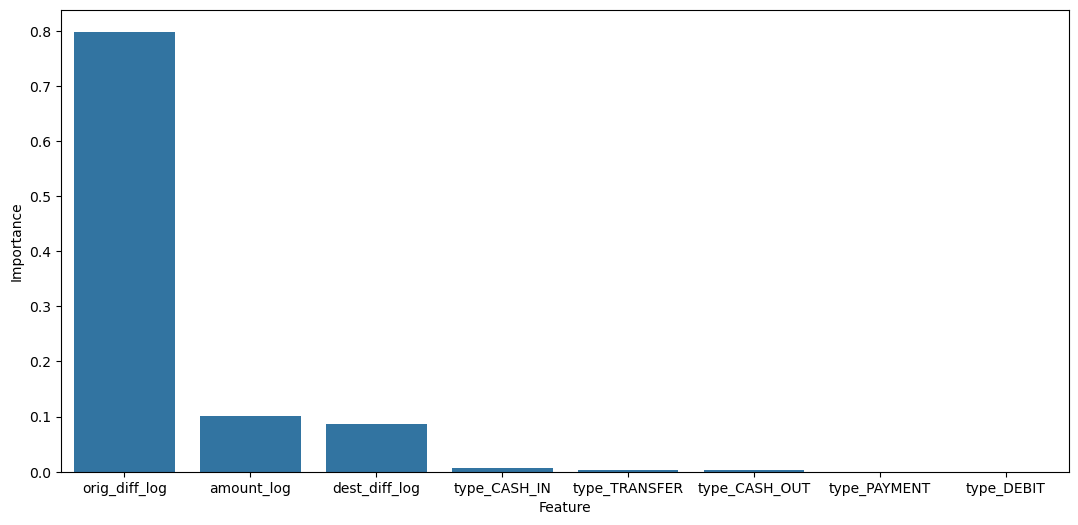

In [64]:
#plot the coeffecient nows from the dataframe above.
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(13,6))
sns.barplot(x='Feature',y='Importance',data=importance_df)



In [26]:
y.value_counts()

isFraud
0    998703
1      1297
Name: count, dtype: int64

### I ran 3 Machine Learning Models and compared the recall scores considering those were the most important metrics.

In [21]:
results_df.recall

LogisticRegression    0.976834
RandomForest          0.938224
XGBoost               0.972973
Name: recall, dtype: object

## Second Model

Create a second machine learning object and rerun steps (2) & (3) on this model. Compare accuracy metrics between these two models. Which handles the class imbalance more effectively?

Create as many code-blocks as needed.

### (Bonus/Optional) Third Model

Create a third machine learning model and rerun steps (2) & (3) on this model. Which model has the best predictive capabilities? 

Create as many code-blocks as needed.